In [1]:
import os
import umap
import h5py
import random
import sklearn
import datetime 
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from scipy.stats import pearsonr # Pearson cor

In [2]:
# custom 
from common import plotting
from common import dataprocessing

In [3]:
datasets = dataprocessing.load_datasets()

In [73]:
for name in datasets.keys():
    print(name)

TCGA
BRCA
TALL
LAML


In [74]:
datasets

{'TCGA': <common.dataprocessing.MLdataset at 0x7fbe8b83e4d0>,
 'BRCA': <common.dataprocessing.MLdataset at 0x7fbce129aef0>,
 'TALL': <common.dataprocessing.MLdataset at 0x7fbcde0c3f10>,
 'LAML': <common.dataprocessing.MLSurvDataset at 0x7fbce1285ba0>}

In [75]:
def run_umap(name): 
    dataname = name
    tpm_data = datasets[dataname].data
    labels = datasets[dataname].labels
    X_train, X_test, Y_train, Y_test = train_test_split(tpm_data.T, labels, test_size = 0.2)
    mapper = umap.UMAP(verbose = 1,min_dist=0.5, 
        n_neighbors =10, n_epochs = 1000).fit(X_train)
    X_tr_umap = mapper.transform(X_train)
    X_tst_umap = mapper.transform(X_test)
    plotting.plot_umap(X_tr_umap, X_tst_umap, Y_train, Y_test, labels, s = 24)

In [76]:
for name in datasets.keys():
    run_umap(name)

UMAP(min_dist=0.5, n_epochs=1000, n_neighbors=10, verbose=1)
Fri Dec 15 14:12:54 2023 Construct fuzzy simplicial set
Fri Dec 15 14:12:55 2023 Finding Nearest Neighbors
Fri Dec 15 14:12:55 2023 Building RP forest with 10 trees


KeyboardInterrupt: 

In [21]:
import torch
from torch import nn

In [ ]:
### fonction d'initialisation du reseau
def auto_encoder(insize, outsize, bnsize, width=100):
    model = nn.Sequential(
    nn.Linear(insize,width),
    nn.ReLU(),
    nn.Linear(width, width),
    nn.ReLU(),
    nn.Linear(width, bnsize), 
    nn.Linear(bnsize, width),
    nn.ReLU(),
    nn.Linear(width, outsize))
    return model, model[0:5]

In [ ]:
def train_auto_encoder(insize, bnsize, X_train, X_test, nepochs = 100, printstep=10, wd = 1e-3, lr = 0.0001):
    DNN, encoder = auto_encoder(insize, insize, bnsize )
    optimizer = torch.optim.Adam(DNN.parameters(), lr = lr, weight_decay = wd)
    tr_losses, tst_losses, tr_accs, tst_accs = [],[],[],[]
    for i in range(nepochs):
        optimizer.zero_grad() # required
        y_tr_out = DNN(X_train) # feed forward
        y_tst_out = DNN(X_test)
        tr_loss = nn.functional.mse_loss(y_tr_out, X_train) # loss computation
        tst_loss = nn.functional.mse_loss(y_tst_out, X_test) # Softmax -> NLL
        
        tr_acc = pearsonr(y_tr_out.flatten().detach().numpy(), X_train.flatten().detach().numpy()).statistic # Pearson corr. coeff
        tst_acc = pearsonr(y_tst_out.flatten().detach().numpy(), X_test.flatten().detach().numpy()).statistic
            
        if i % printstep == 0 or i+1 == nepochs :
            print(f"Loss {i} Train - loss : {round(float(tr_loss),2)} - acc : {round(float(tr_acc),2)} Test acc : {round(tst_acc,2)}")
        tr_loss.backward() # back prop
        optimizer.step() # optimizer update
        [tr_losses.append(float(tr_loss)), tst_losses.append(float(tst_loss)), tr_accs.append(tr_acc), tst_accs.append(tst_acc)]
    return DNN, np.array(tr_losses), np.array(tst_losses), np.array(tr_accs), np.array(tst_accs)


In [ ]:
def run_ae(name):
    labels = datasets[name].labels
    tpm_data = datasets[name].data
    lblbin = LabelBinarizer()
    Y = torch.Tensor(lblbin.fit_transform(labels))
    X_train, X_test, Y_train,  Y_test = train_test_split(torch.Tensor(tpm_data.T), torch.Tensor(Y),test_size=0.2)
    insize = X_train.shape[1] ## some model setting variables
    mm, trl, tstl, trc, tstc  = train_auto_encoder(insize, 2, X_train, X_test, nepochs = 1000, lr = 5 * 1e-4)
    plotting.plot_learning_curves(trl, tstl, trc, tstc, tpm_data, X_train, X_test)
    plotting.plot_ae_performance(mm, X_test, dataset=name)

Loss 0 Train - loss : 1.01 - acc : -0.01 Test acc : -0.01
Loss 10 Train - loss : 0.92 - acc : 0.11 Test acc : 0.11
Loss 20 Train - loss : 0.84 - acc : 0.24 Test acc : 0.24
Loss 30 Train - loss : 0.72 - acc : 0.32 Test acc : 0.32
Loss 40 Train - loss : 0.44 - acc : 0.52 Test acc : 0.51
Loss 50 Train - loss : 0.22 - acc : 0.75 Test acc : 0.75
Loss 60 Train - loss : 0.15 - acc : 0.83 Test acc : 0.83
Loss 70 Train - loss : 0.14 - acc : 0.84 Test acc : 0.84
Loss 80 Train - loss : 0.14 - acc : 0.85 Test acc : 0.85
Loss 90 Train - loss : 0.13 - acc : 0.85 Test acc : 0.85
Loss 100 Train - loss : 0.13 - acc : 0.85 Test acc : 0.85
Loss 110 Train - loss : 0.13 - acc : 0.85 Test acc : 0.85
Loss 120 Train - loss : 0.13 - acc : 0.85 Test acc : 0.85
Loss 130 Train - loss : 0.13 - acc : 0.85 Test acc : 0.85
Loss 140 Train - loss : 0.13 - acc : 0.85 Test acc : 0.85
Loss 150 Train - loss : 0.13 - acc : 0.85 Test acc : 0.85
Loss 160 Train - loss : 0.13 - acc : 0.85 Test acc : 0.85
Loss 170 Train - loss :

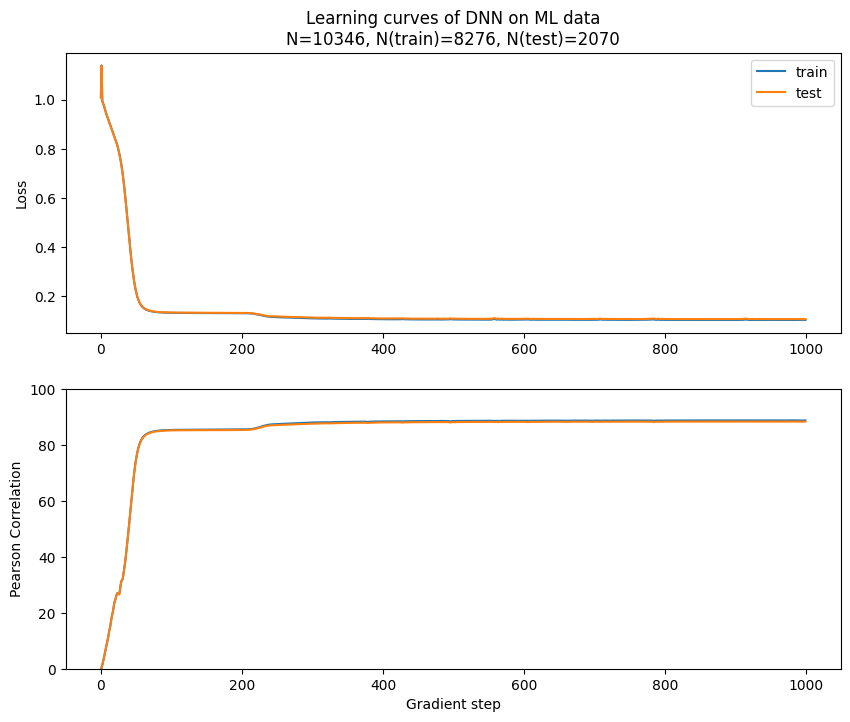

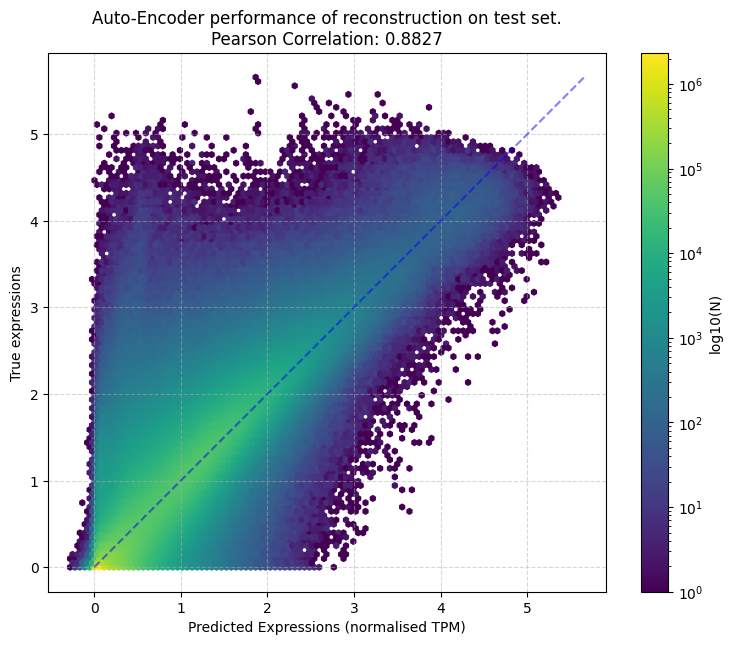

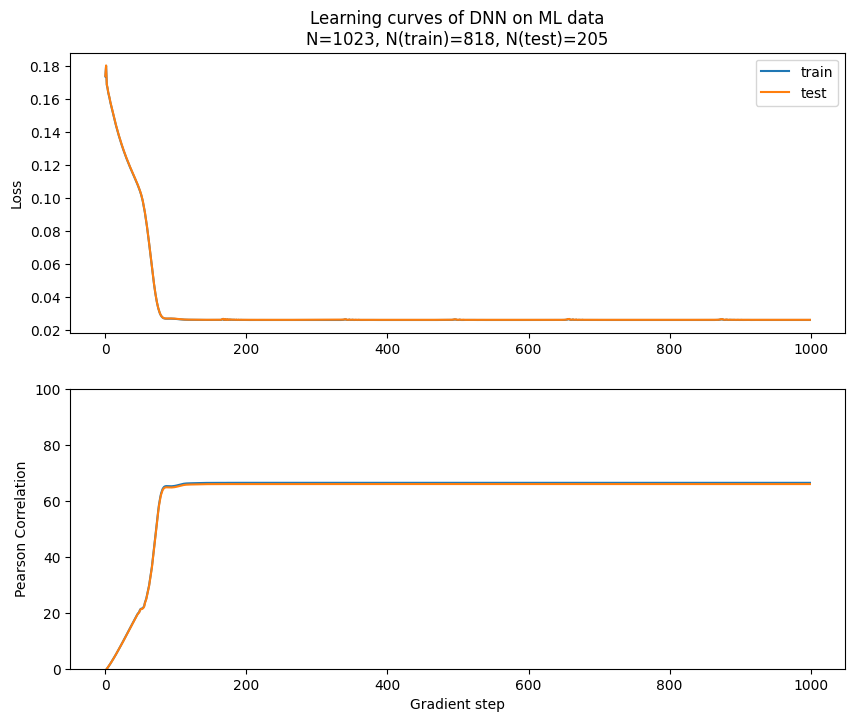

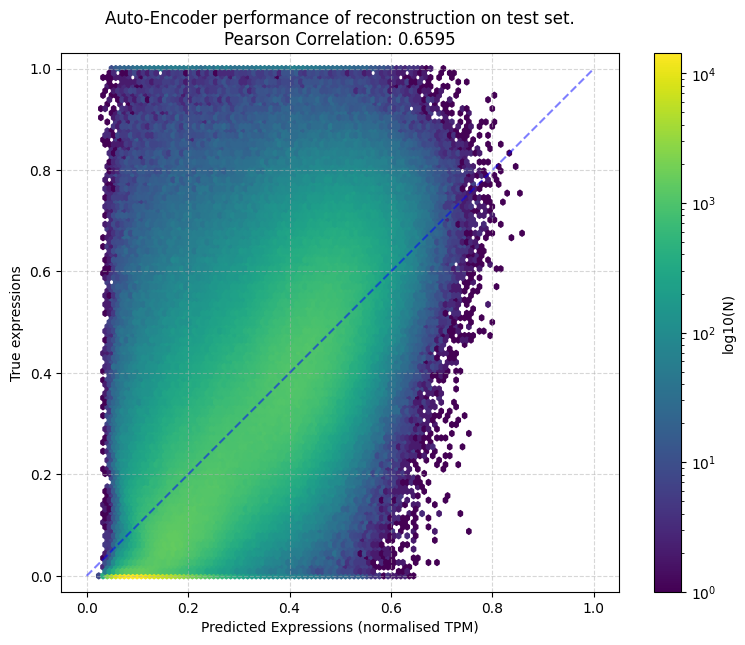

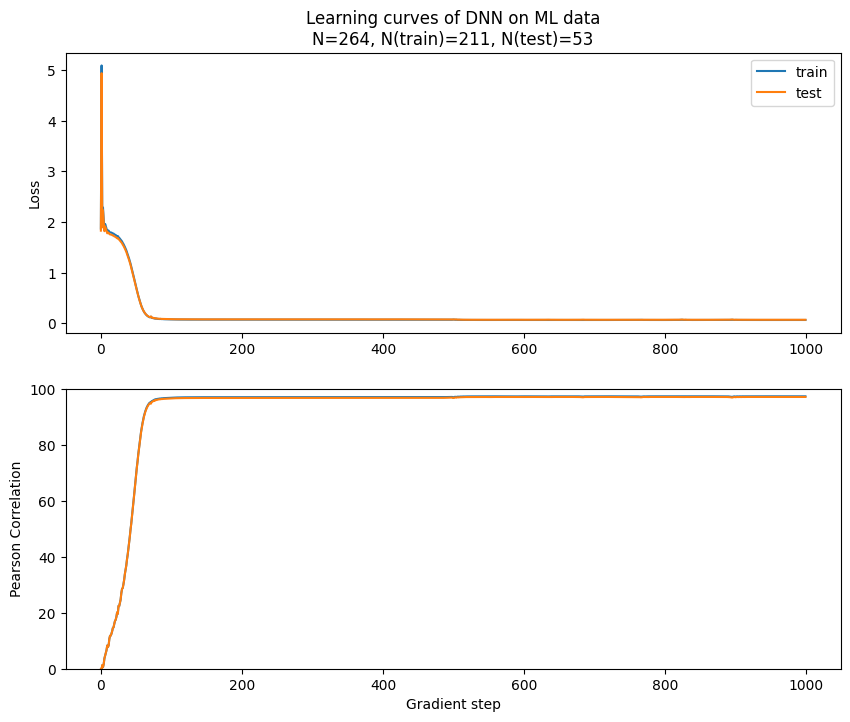

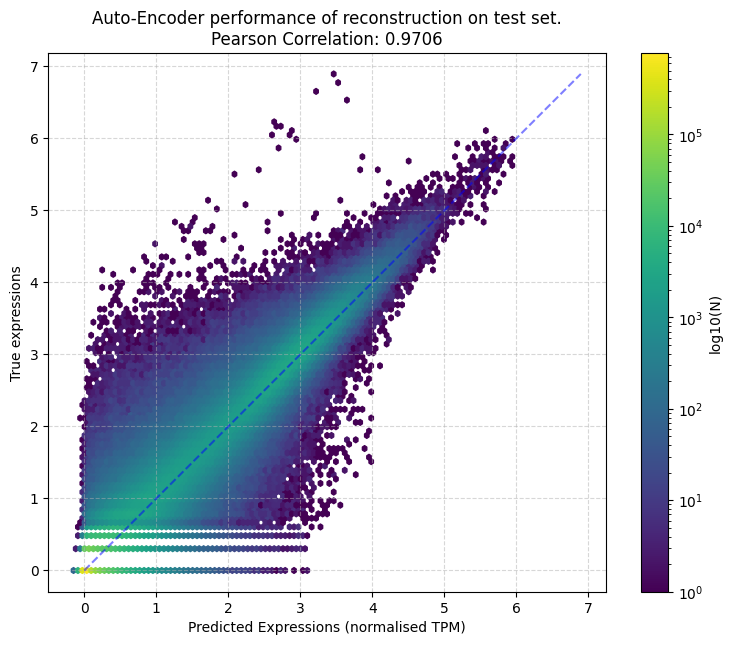

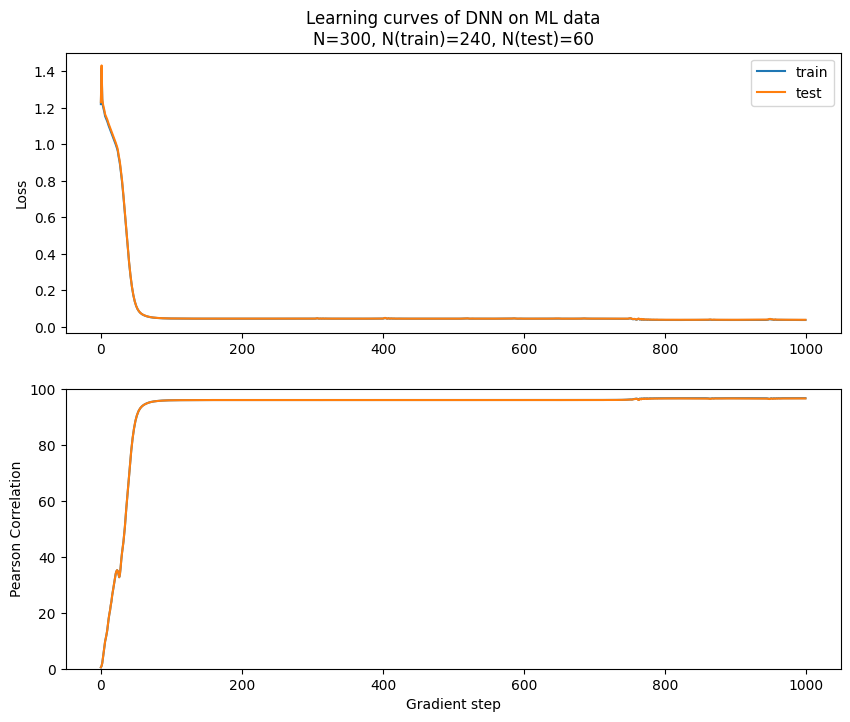

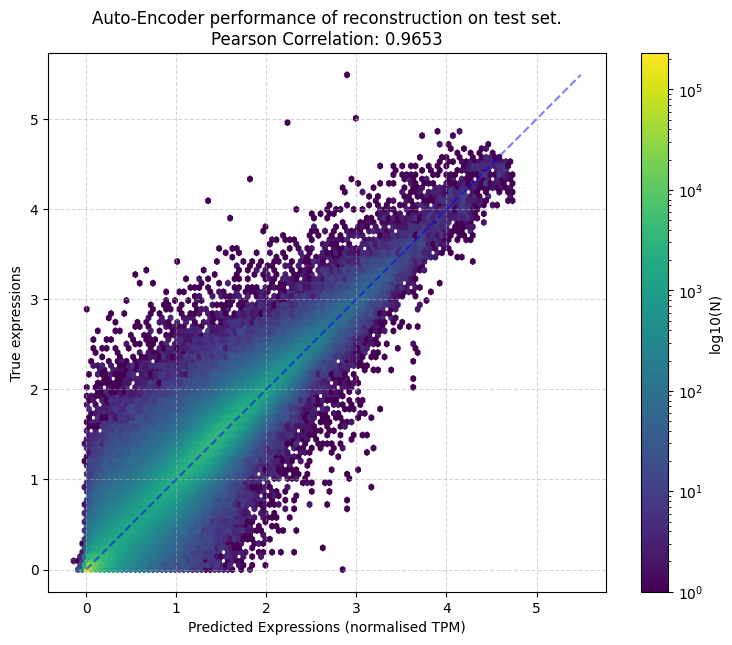

In [ ]:
for name in datasets.keys():
    run_ae(name)

## Partie III

In [ ]:
import torch.nn.functional as F
class VariationalEncoder(nn.Module):
    def __init__(self, insize, latent_dims, width = 100):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(insize, width)
        self.linear2 = nn.Linear(width, latent_dims)
        self.linear3 = nn.Linear(width, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        #self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale # .cuda()
        self.kl = 0
    
    def forward(self, x):
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

class Decoder(nn.Module):
    def __init__(self, insize, latent_dims, width = 100):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, width)
        self.linear2 = nn.Linear(width, insize)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        return self.linear2(z)
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, insize, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(insize, latent_dims)
        self.decoder = Decoder(insize, latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
        

In [18]:
from common import engines

In [19]:
def run_vae(name):
    labels = datasets[name].labels
    tpm_data = datasets[name].data
    lblbin = LabelBinarizer()
    Y = torch.Tensor(lblbin.fit_transform(labels))
    X_train, X_test, Y_train,  Y_test = train_test_split(torch.Tensor(tpm_data.T), torch.Tensor(Y),test_size=0.2)
    insize = X_train.shape[1] ## some model setting variables
    VAE, trl, tstl, trc, tstc = engines.train_variational_auto_encoder(insize, 125, X_train, X_test, nepochs = 1000, printstep = 10, wd = 1e-3, lr = 1e-3)
    plotting.plot_learning_curves(trl, tstl, trc, tstc, tpm_data, X_train, X_test)
    plotting.plot_ae_performance(VAE, X_test, modeltype ="VAE", dataset = name)


Loss 0 Train - loss : 1.049 - acc : -0.0 Test acc : -0.0
Loss 10 Train - loss : 1.344 - acc : 0.156 Test acc : 0.156
Loss 20 Train - loss : 0.562 - acc : 0.427 Test acc : 0.428
Loss 30 Train - loss : 0.29 - acc : 0.675 Test acc : 0.676
Loss 40 Train - loss : 0.178 - acc : 0.807 Test acc : 0.808
Loss 50 Train - loss : 0.145 - acc : 0.84 Test acc : 0.841
Loss 60 Train - loss : 0.137 - acc : 0.848 Test acc : 0.849
Loss 70 Train - loss : 0.135 - acc : 0.851 Test acc : 0.852
Loss 80 Train - loss : 0.134 - acc : 0.852 Test acc : 0.853
Loss 90 Train - loss : 0.134 - acc : 0.853 Test acc : 0.853
Loss 100 Train - loss : 0.133 - acc : 0.853 Test acc : 0.854
Loss 110 Train - loss : 0.133 - acc : 0.853 Test acc : 0.854
Loss 120 Train - loss : 0.133 - acc : 0.853 Test acc : 0.854
Loss 130 Train - loss : 0.133 - acc : 0.853 Test acc : 0.854
Loss 140 Train - loss : 0.133 - acc : 0.853 Test acc : 0.854
Loss 150 Train - loss : 0.133 - acc : 0.853 Test acc : 0.854
Loss 160 Train - loss : 0.133 - acc : 0

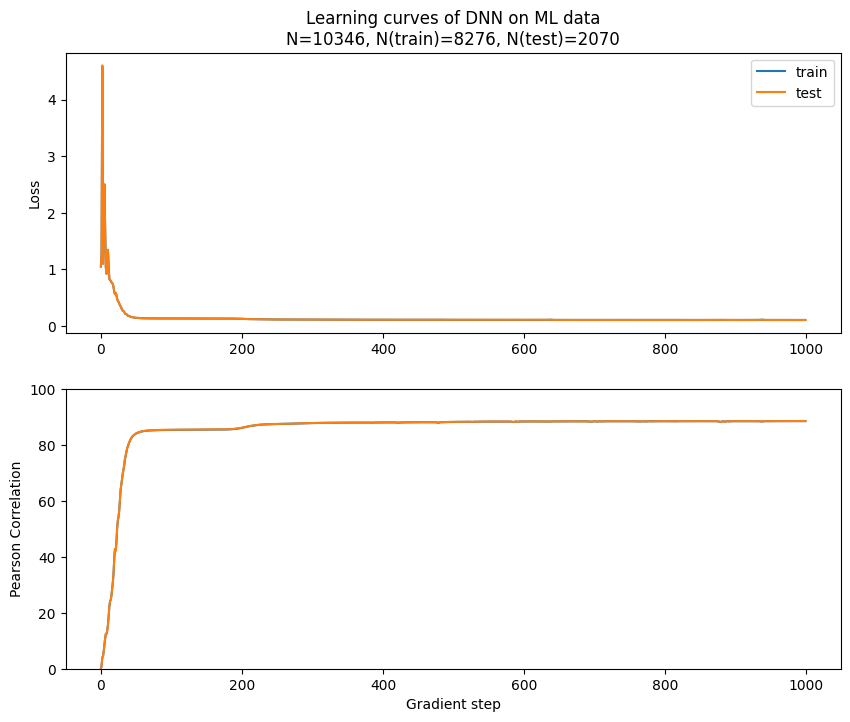

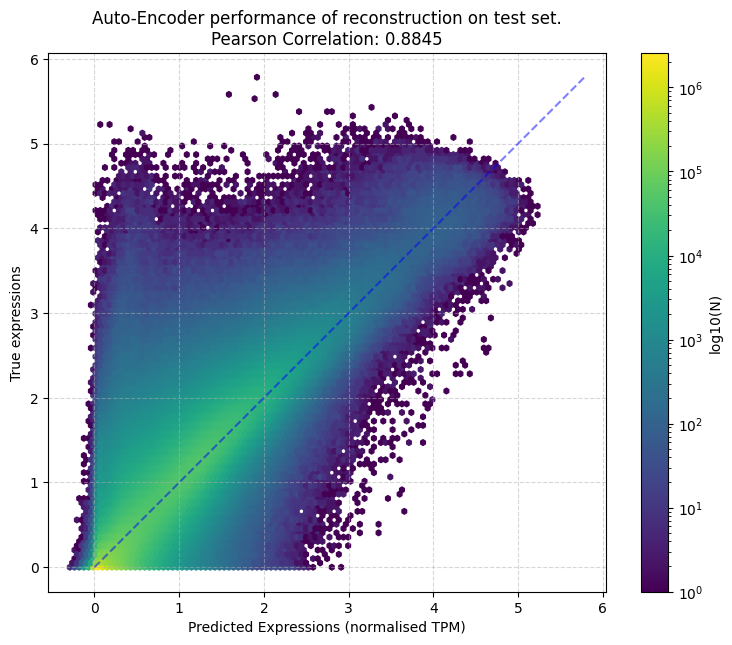

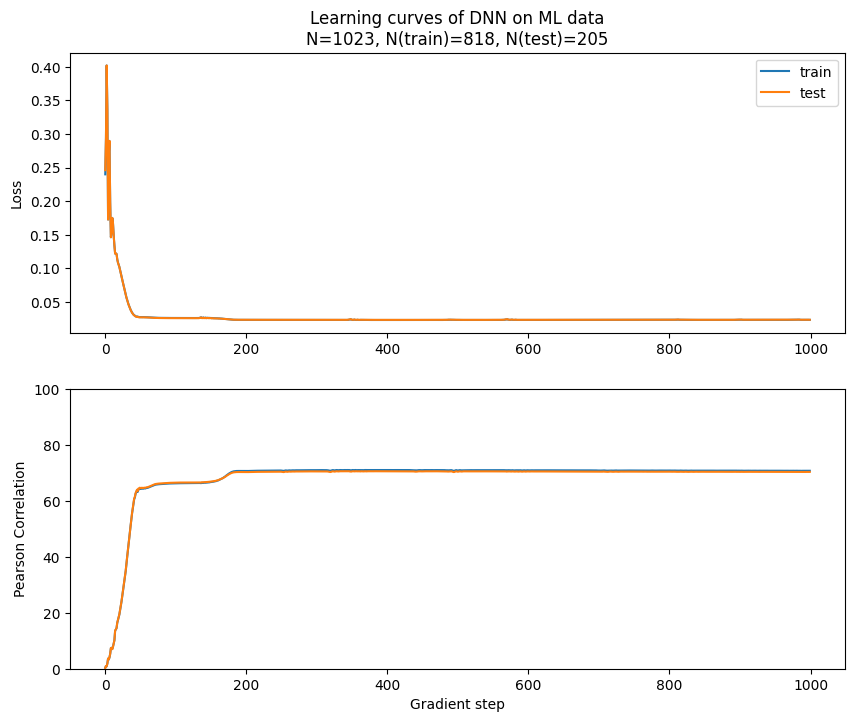

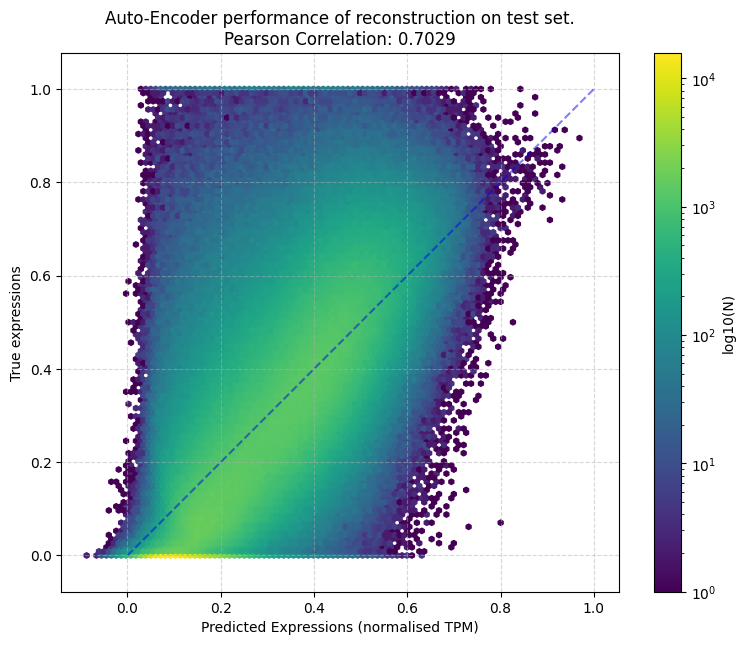

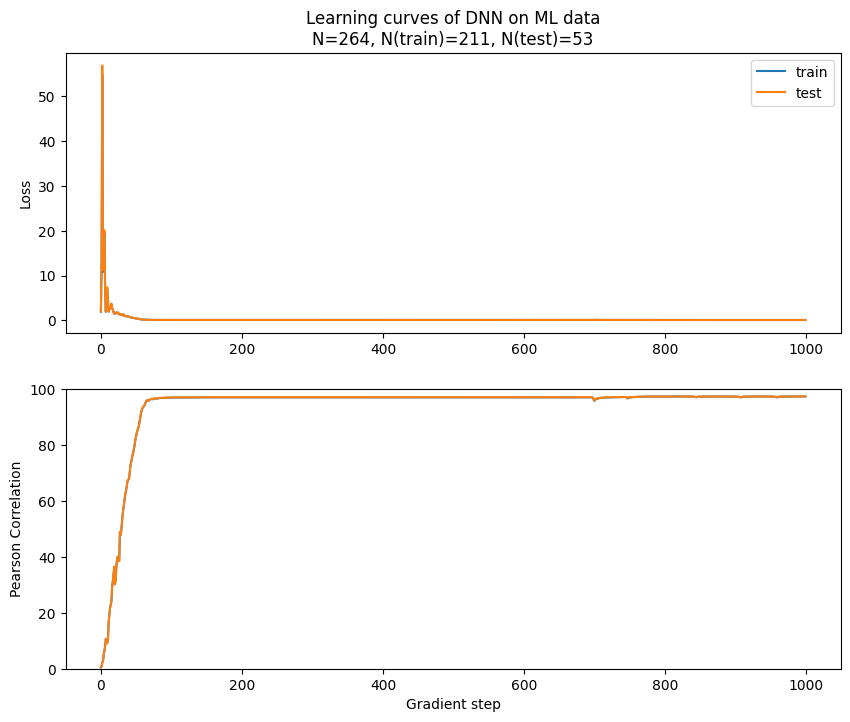

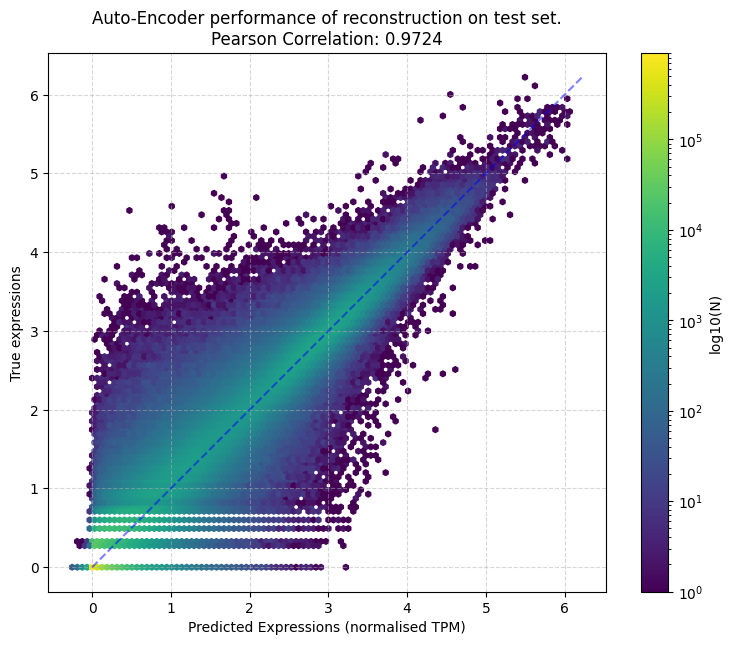

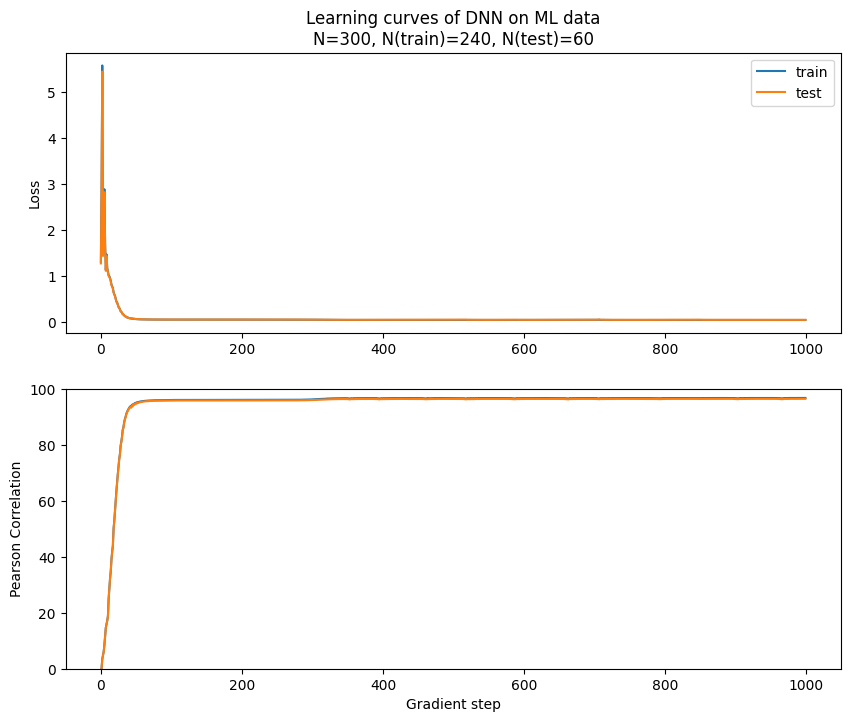

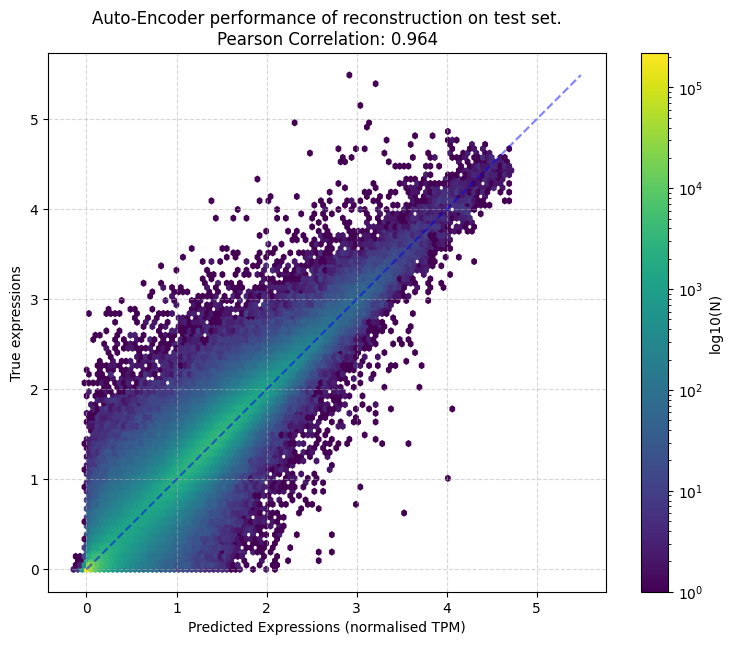

In [ ]:
for name in datasets.keys():
    run_vae(name)

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
def supervised_umap(name):
    labels = datasets[name].labels
    tpm_data = datasets[name].data
    lblenc = LabelEncoder()
    lblenc.fit(labels)
    Y = lblenc.transform(labels)
    X_train, X_test, Y_train, Y_test = train_test_split(tpm_data.T, Y, test_size = 0.2)
    mapper = umap.UMAP(verbose = 1, n_components = 2, min_dist=1., 
        n_neighbors =5, n_epochs = 1000).fit(X_train,  y = Y_train)
    X_tr_umap = mapper.transform(X_train)
    X_tst_umap = mapper.transform(X_test)
    plotting.plot_umap(X_tr_umap, X_tst_umap, lblenc.inverse_transform(Y_train), lblenc.inverse_transform(Y_test), labels, s = 24)

UMAP(min_dist=1.0, n_epochs=1000, n_neighbors=5, verbose=1)
Thu Dec 14 20:03:06 2023 Construct fuzzy simplicial set
Thu Dec 14 20:03:07 2023 Finding Nearest Neighbors
Thu Dec 14 20:03:07 2023 Building RP forest with 10 trees
Thu Dec 14 20:03:08 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations
Thu Dec 14 20:03:08 2023 Finished Nearest Neighbor Search
Thu Dec 14 20:03:09 2023 Construct embedding


/usr/local/python-3.10.12/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Thu Dec 14 20:03:34 2023 Finished embedding
Thu Dec 14 20:03:36 2023 Worst tree score: 0.45807153
Thu Dec 14 20:03:36 2023 Mean tree score: 0.47312711
Thu Dec 14 20:03:36 2023 Best tree score: 0.48320445
Thu Dec 14 20:03:36 2023 Forward diversification reduced edges from 41380 to 26034
Thu Dec 14 20:03:36 2023 Reverse diversification reduced edges from 26034 to 26034
Thu Dec 14 20:03:36 2023 Degree pruning reduced edges from 26112 to 25602
Thu Dec 14 20:03:36 2023 Resorting data and graph based on tree order
Thu Dec 14 20:03:36 2023 Building and compiling search function


Epochs completed:   0%|            0/333 [00:00]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs
UMAP(min_dist=1.0, n_epochs=1000, n_neighbors=5, verbose=1)
Thu Dec 14 20:03:44 2023 Construct fuzzy simplicial set
Thu Dec 14 20:03:45 2023 Finding Nearest Neighbors
Thu Dec 14 20:03:45 2023 Finished Nearest Neighbor Search
Thu Dec 14 20:03:45 2023 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Thu Dec 14 20:03:49 2023 Finished embedding


Epochs completed:   0%|            0/333 [00:00]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs
UMAP(min_dist=1.0, n_epochs=1000, n_neighbors=5, verbose=1)
Thu Dec 14 20:03:53 2023 Construct fuzzy simplicial set
Thu Dec 14 20:03:54 2023 Finding Nearest Neighbors
Thu Dec 14 20:03:54 2023 Finished Nearest Neighbor Search
Thu Dec 14 20:03:54 2023 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Thu Dec 14 20:03:56 2023 Finished embedding


Epochs completed:   0%|            0/333 [00:00]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs
UMAP(min_dist=1.0, n_epochs=1000, n_neighbors=5, verbose=1)
Thu Dec 14 20:03:59 2023 Construct fuzzy simplicial set
Thu Dec 14 20:04:00 2023 Finding Nearest Neighbors
Thu Dec 14 20:04:00 2023 Finished Nearest Neighbor Search
Thu Dec 14 20:04:00 2023 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Thu Dec 14 20:04:02 2023 Finished embedding


Epochs completed:   0%|            0/333 [00:00]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs


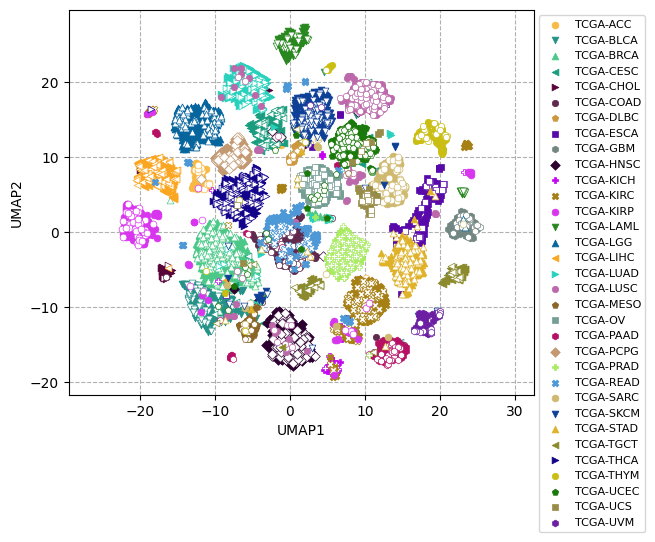

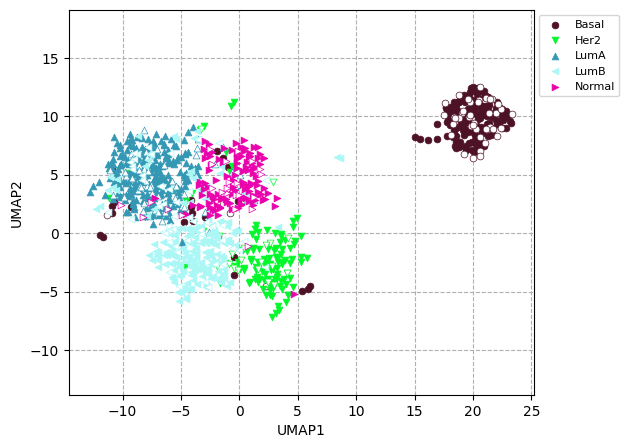

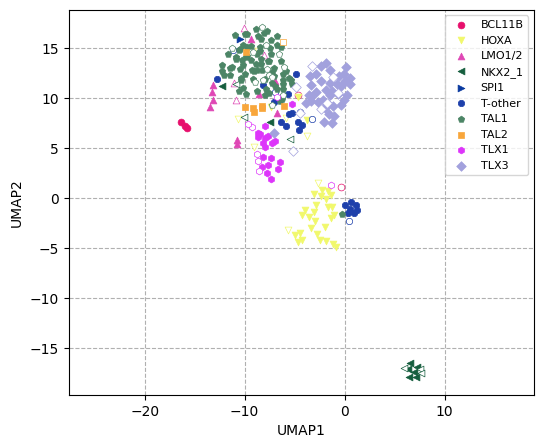

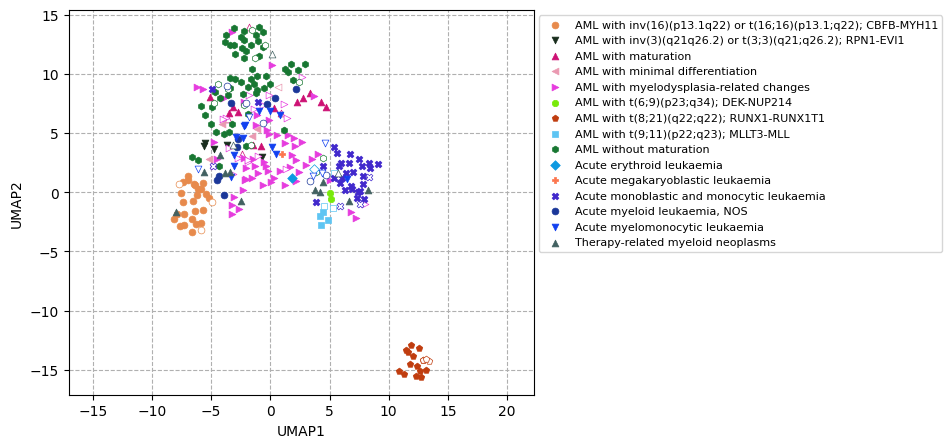

In [ ]:
for name in datasets.keys():
    supervised_umap(name)

In [ ]:
datasets["TCGA"].data

array([[2.1380138 , 1.6472441 , 2.4257395 , ..., 1.5517805 , 0.05514891,
        1.5976514 ],
       [0.34283704, 1.1426053 , 1.0648696 , ..., 0.9368906 , 2.3453155 ,
        1.2062347 ],
       [2.526551  , 0.9517891 , 1.5807666 , ..., 0.5234863 , 0.0991625 ,
        1.7828873 ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 1.1119142 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.1052921 ,
        0.        ],
       [0.92262685, 0.8765296 , 0.99977845, ..., 1.4316387 , 1.0555313 ,
        1.033291  ]], dtype=float32)

In [ ]:
np.unique(datasets["TCGA"].labels)

array(['TCGA-ACC', 'TCGA-BLCA', 'TCGA-BRCA', 'TCGA-CESC', 'TCGA-CHOL',
       'TCGA-COAD', 'TCGA-DLBC', 'TCGA-ESCA', 'TCGA-GBM', 'TCGA-HNSC',
       'TCGA-KICH', 'TCGA-KIRC', 'TCGA-KIRP', 'TCGA-LAML', 'TCGA-LGG',
       'TCGA-LIHC', 'TCGA-LUAD', 'TCGA-LUSC', 'TCGA-MESO', 'TCGA-OV',
       'TCGA-PAAD', 'TCGA-PCPG', 'TCGA-PRAD', 'TCGA-READ', 'TCGA-SARC',
       'TCGA-SKCM', 'TCGA-STAD', 'TCGA-TGCT', 'TCGA-THCA', 'TCGA-THYM',
       'TCGA-UCEC', 'TCGA-UCS', 'TCGA-UVM'], dtype='<U9')

In [4]:
keep = [i for (i,l) in enumerate(datasets["TCGA"].labels) if l in ['TCGA-GBM', 'TCGA-LGG'] ]
samples = np.array(datasets["TCGA"].samples, dtype = str)[keep]
tpm_data = datasets["TCGA"].data[:,keep]
labels = np.array(datasets["TCGA"].labels, dtype = str)[keep]

In [5]:
labels.shape

(676,)

In [6]:
keep1 = [i for (i,l) in enumerate(labels) if l == 'TCGA-GBM' ]
keep2 = [i for (i,l) in enumerate(labels) if l == 'TCGA-LGG' ]


In [7]:
gbmX2_gene = tpm_data.copy()
lggX2_gene = tpm_data.copy()
lggX3_gene = tpm_data.copy()

In [8]:
def modify_gene(array, condition, multiplier):
    for i in range(len(array)):
        if i % 2 == condition:
            array[i]*=multiplier


In [9]:
modify_gene(gbmX2_gene, 0, 2)
modify_gene(lggX2_gene, 0, 2)
modify_gene(lggX3_gene, 1, 3)

In [10]:
def modify_sample(array, condition, multiplier, keep_array):
    for index in keep_array:
        if index % 2 == condition:
            array[:, index]*=multiplier

In [11]:
gbmX2_sample = tpm_data.copy()
lggX2_sample = tpm_data.copy()
lggX3_sample = tpm_data.copy()

In [12]:
modify_sample(gbmX2_sample, 0, 2, keep1)
modify_sample(lggX2_sample, 0, 2, keep2)
modify_sample(lggX3_sample, 1, 3, keep2)

In [14]:
gbmX2_gene[:, 16]

array([3.5845115, 1.0818907, 2.9555445, ..., 0.       , 0.       ,
       1.9168698], dtype=float32)

In [13]:
gbmX2_sample[:, 16]

array([3.5845115, 2.1637814, 2.9555445, ..., 0.       , 0.       ,
       1.9168698], dtype=float32)

In [ ]:
datasets['TCGA'].data[0]

array([2.1380138 , 1.6472441 , 2.4257395 , ..., 1.5517805 , 0.05514891,
       1.5976514 ], dtype=float32)

In [15]:
syn_datasets = {"GBMX2_gene" : gbmX2_gene, "LGGX2_gene" : lggX2_gene, "LGGX3_gene" : lggX3_gene
                , "GBMX2_sample" : gbmX2_sample, "LGGX2_sample" : lggX2_sample, "LGGX3_sample" : lggX3_sample}

UMAP(min_dist=0.5, n_epochs=1000, n_neighbors=10, verbose=1)
Fri Dec 15 14:27:32 2023 Construct fuzzy simplicial set
Fri Dec 15 14:27:33 2023 Finding Nearest Neighbors
Fri Dec 15 14:27:35 2023 Finished Nearest Neighbor Search
Fri Dec 15 14:27:38 2023 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Fri Dec 15 14:27:41 2023 Finished embedding


Epochs completed:   0%|            0/333 [00:00]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs
UMAP(min_dist=0.5, n_epochs=1000, n_neighbors=10, verbose=1)
Fri Dec 15 14:27:48 2023 Construct fuzzy simplicial set
Fri Dec 15 14:27:49 2023 Finding Nearest Neighbors
Fri Dec 15 14:27:49 2023 Finished Nearest Neighbor Search
Fri Dec 15 14:27:49 2023 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Fri Dec 15 14:27:52 2023 Finished embedding


Epochs completed:   0%|            0/333 [00:00]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs
UMAP(min_dist=0.5, n_epochs=1000, n_neighbors=10, verbose=1)
Fri Dec 15 14:27:55 2023 Construct fuzzy simplicial set
Fri Dec 15 14:27:56 2023 Finding Nearest Neighbors
Fri Dec 15 14:27:56 2023 Finished Nearest Neighbor Search
Fri Dec 15 14:27:56 2023 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Fri Dec 15 14:27:59 2023 Finished embedding


Epochs completed:   0%|            0/333 [00:00]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs
UMAP(min_dist=0.5, n_epochs=1000, n_neighbors=10, verbose=1)
Fri Dec 15 14:28:02 2023 Construct fuzzy simplicial set
Fri Dec 15 14:28:02 2023 Finding Nearest Neighbors
Fri Dec 15 14:28:02 2023 Finished Nearest Neighbor Search
Fri Dec 15 14:28:02 2023 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Fri Dec 15 14:28:06 2023 Finished embedding


Epochs completed:   0%|            0/333 [00:00]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs
UMAP(min_dist=0.5, n_epochs=1000, n_neighbors=10, verbose=1)
Fri Dec 15 14:28:08 2023 Construct fuzzy simplicial set
Fri Dec 15 14:28:09 2023 Finding Nearest Neighbors
Fri Dec 15 14:28:09 2023 Finished Nearest Neighbor Search
Fri Dec 15 14:28:09 2023 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Fri Dec 15 14:28:12 2023 Finished embedding


Epochs completed:   0%|            0/333 [00:00]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs
UMAP(min_dist=0.5, n_epochs=1000, n_neighbors=10, verbose=1)
Fri Dec 15 14:28:15 2023 Construct fuzzy simplicial set
Fri Dec 15 14:28:15 2023 Finding Nearest Neighbors
Fri Dec 15 14:28:15 2023 Finished Nearest Neighbor Search
Fri Dec 15 14:28:15 2023 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Fri Dec 15 14:28:19 2023 Finished embedding


Epochs completed:   0%|            0/333 [00:00]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs


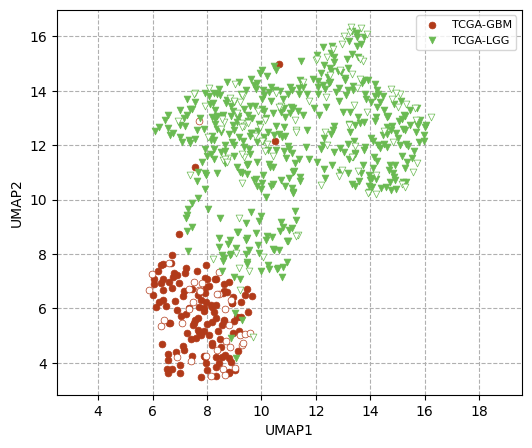

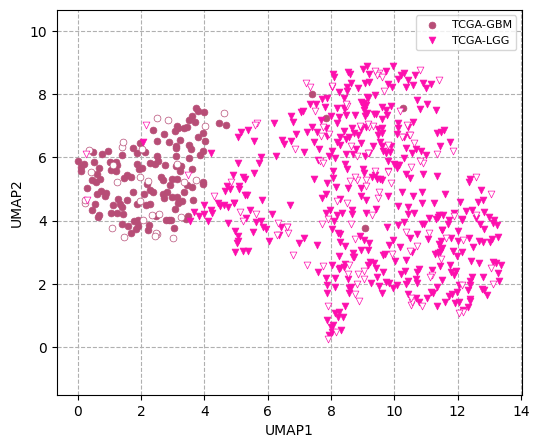

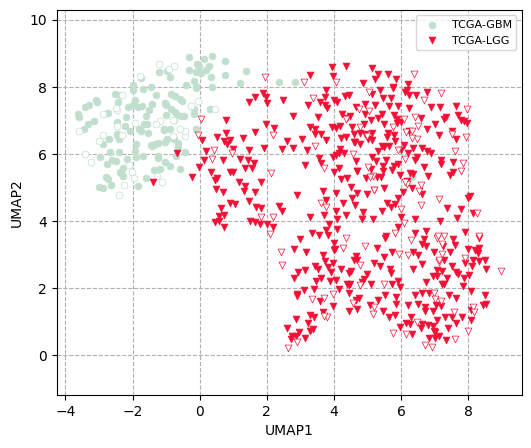

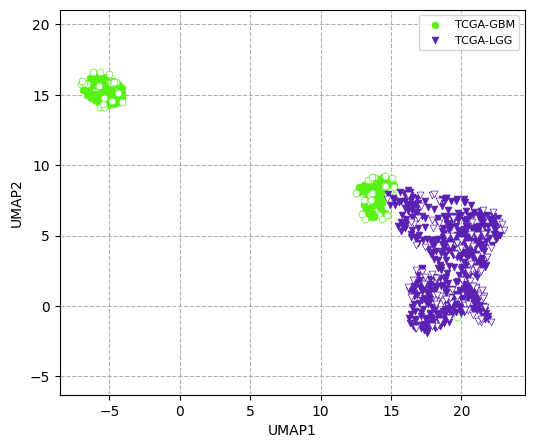

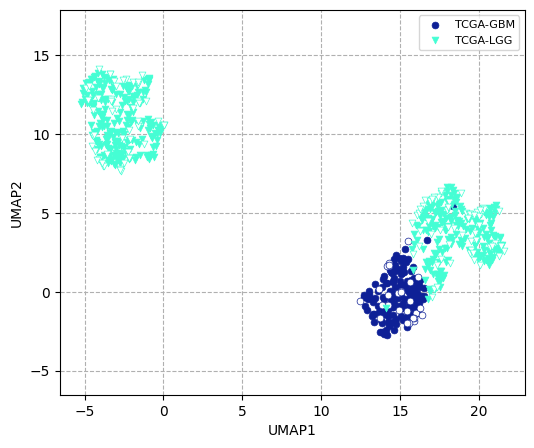

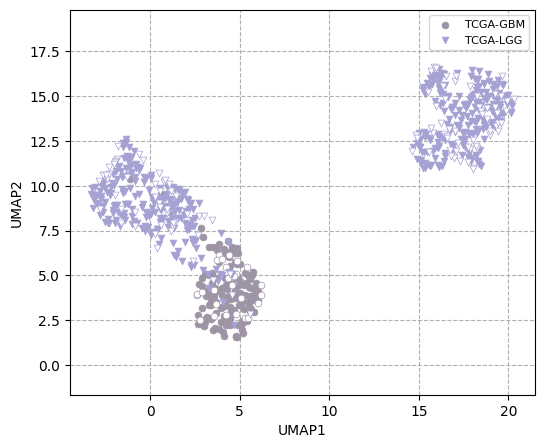

In [17]:
for key in syn_datasets.keys():
    syn_data = syn_datasets[key]
    X_train, X_test, Y_train, Y_test = train_test_split(syn_data.T, labels, test_size = 0.2)
    mapper = umap.UMAP(verbose = 1,min_dist=0.5, 
        n_neighbors =10, n_epochs = 1000).fit(X_train)
    X_tr_umap = mapper.transform(X_train)
    X_tst_umap = mapper.transform(X_test)
    plotting.plot_umap(X_tr_umap, X_tst_umap, Y_train, Y_test, labels, s = 24)

In [29]:
for name in syn_datasets.keys():
    tpm_data = syn_datasets[name]
    lblbin = LabelBinarizer()
    Y = torch.Tensor(lblbin.fit_transform(labels))
    X_train, X_test, Y_train,  Y_test = train_test_split(torch.Tensor(tpm_data.T), torch.Tensor(Y),test_size=0.2)
    insize = X_train.shape[1] ## some model setting variables
    VAE, trl, tstl, trc, tstc = engines.train_variational_auto_encoder(insize, 125, X_train, X_test, nepochs = 100, printstep = 10, wd = 1e-3, lr = 1e-3)
    plotting.plot_learning_curves(trl, tstl, trc, tstc, tpm_data, X_train, X_test)
    plotting.plot_ae_performance(VAE, X_test, modeltype ="VAE", dataset = name)
    prediction = VAE(X_test)
    outs = prediction.detach().numpy()
    trues = X_test.detach().numpy()
    X_train = X_train.detach().numpy()
    Y_train = Y_train.detach().numpy()
    mapper = umap.UMAP(verbose = 1,min_dist=0.5, 
        n_neighbors =10, n_epochs = 1000).fit(X_train)
    X_tr_umap = mapper.transform(X_train)
    X_tst_umap = mapper.transform(trues)
    plotting.plot_umap(X_train, trues, Y_train, outs, labels, s = 24)


Loss 0 Train - loss : 2.616 - acc : 0.004 Test acc : 0.004


tensor([[ 1.6000,  0.7840,  0.7627,  ..., -0.0286,  0.0653,  1.4044],
        [ 1.7868,  0.8708,  0.8333,  ..., -0.0375,  0.0698,  1.5028],
        [ 1.5325,  0.7412,  0.7336,  ..., -0.0316,  0.0626,  1.3500],
        ...,
        [ 1.4315,  0.6696,  0.6880,  ..., -0.0393,  0.0577,  1.2573],
        [ 1.6406,  0.7956,  0.7758,  ..., -0.0345,  0.0656,  1.4138],
        [ 1.5674,  0.7357,  0.7400,  ..., -0.0449,  0.0614,  1.3326]],
       grad_fn=<AddmmBackward0>)